# Exothermic Continuous Stirred Tank Reactor

## Description

This example is intended as an introduction to the nonlinear dynamics of an exothermic continuous stirred-tank reactor. The example has been studied by countless researchers and students since the pioneering work of Amundson and Aris in the 1950's. The particular formulation and parameter values described below are taken from example 2.5 from Seborg, Edgar, Mellichamp and Doyle (SEMD).

![Exothermic Reactor](https://upload.wikimedia.org/wikipedia/commons/thumb/b/be/Agitated_vessel.svg/500px-Agitated_vessel.svg.png)

(Diagram By [Daniele Pugliesi](https://commons.wikimedia.org/wiki/User:Daniele_Pugliesi) - Own work, [CC BY-SA 3.0](http://creativecommons.org/licenses/by-sa/3.0), [Link](https://commons.wikimedia.org/w/index.php?curid=6915706))

## Reaction Kinetics

We assume the kinetics are dominated by a single first order reaction

$$A \xrightarrow{kc_A}{} \text{Products}$$

The reaction rate per unit volume is modeled as the product $kc_A$ where $c_A$ is the concentration of $A$. The rate constant $k(T)$ is a increases with temperature following the Arrehenius law

$$k(t) = k_0 e^{-\frac{E_a}{RT}}$$

$E_a$ is the activation energy, $R$ is the gas constant, $T$ is absolute temperature, and $k_0$ is the pre-exponential factor. 

We can see the strong temperature dependence by plotting $k(T)$ versus temperature over typical operating conditions.

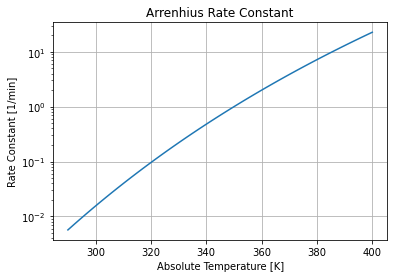

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Arrehnius parameters
Ea = 72750     # activation energy J/gmol
R = 8.314      # gas constant J/gmol/K
k0 = 7.2e10    # Arrhenius rate constant 1/min

# Arrhenius rate expression
def k(T):
    return k0*np.exp(-Ea/(R*T))

# semilog plot of the rate constant
T = np.linspace(290,400)
plt.semilogy(T, k(T))
plt.xlabel('Absolute Temperature [K]')
plt.ylabel('Rate Constant [1/min]')
plt.title('Arrenhius Rate Constant')
plt.grid();

This graph shows the reaction rate changes by three orders of magnitude over the range of possible operating temperatures. Because an exothermic reaction releases heat faster at higher temperatures, there is a positive feedback that can potentially result in unstable process behavior.

## Model Equations and Parameter Values

The model consists of mole and energy balances on the contents of the well-mixed reactor.

$$
\begin{align*}
V\frac{dc_A}{dt} & = q(c_{Ai}-c_A)-Vkc_A \\
V\rho C_p\frac{dT}{dt} & = wC_p(T_i-T) + (-\Delta H_R)Vkc_A + UA(T_c-T)
\end{align*}
$$

Normalizing the equations to isolate the time rates of change of $c_A$ and $T$ give

$$
\begin{align*}
\frac{dc_A}{dt} & = \frac{q}{V}(c_{Ai} - c_A)- kc_A \\
\frac{dT}{dt} & = \frac{q}{V}(T_i - T) + \frac{-\Delta H_R}{\rho C_p}kc_A + \frac{UA}{V\rho C_p}(T_c - T)
\end{align*}
$$

which are the equations that will be integrated below.

| Quantity | Symbol | Value | Units | Comments |
| :------- | :----: | :---: | :---- | |
| Activation Energy | $E_a$ | 72,750 | J/gmol | |
| Arrehnius pre-exponential | $k_0$ | 7.2 x 10<sup>10</sup> | 1/min | |
| Gas Constant | $R$ | 8.314 | J/gmol/K | |
| Reactor Volume | $V$ | 100 | liters | |
| Density | $\rho$ | 1000 | g/liter | |
| Heat Capacity | $C_p$ | 0.239 | J/g/K | |
| Enthalpy of Reaction | $\Delta H_r$ | -50,000 | J/gmol | |
| Heat Transfer Coefficient | $UA$ | 50,000 | J/min/K | |
| Feed flowrate | $q$ | 100 | liters/min | |
| Feed concentration | $c_{A,f}$ | 1.0 | gmol/liter | |
| Feed temperature | $T_f$ | 350 | K | |
| Initial concentration | $c_{A,0}$ | 0.5 | gmol/liter | |
| Initial temperature | $T_0$ | 350 | K | |
| Coolant temperature | $T_c$ | 300 | K | Primary Manipulated Variable |



## Transient Behavior

The first simulation assumes a cooling water temperature of 300 K. 

In [34]:
from scipy.integrate import solve_ivp

Ea  = 72750     # activation energy J/gmol
R   = 8.314     # gas constant J/gmol/K
k0  = 7.2e10    # Arrhenius rate constant 1/min
V   = 100.0     # Volume [L]
rho = 1000.0    # Density [g/L]
Cp  = 0.239     # Heat capacity [J/g/K]
dHr = -5.0e4    # Enthalpy of reaction [J/mol]
UA  = 5.0e4     # Heat transfer [J/min/K]
q   = 100.0     # Flowrate [L/min]
cAi = 1.0       # Inlet feed concentration [mol/L]
Ti  = 350.0     # Inlet feed temperature [K]
cA0 = 0.5;      # Initial concentration [mol/L]
T0  = 350.0;    # Initial temperature [K]
Tc  = 300.0     # Coolant temperature [K]

def deriv(t, y):
    cA,T = y
    dcAdt = (q/V)*(cAi - cA) - k(T)*cA
    dTdt = (q/V)*(Ti - T) + (-dHr/rho/Cp)*k(T)*cA + (UA/V/rho/Cp)*(Tc-T)
    return [dcAdt, dTdt]

We first define a visualization function that will be reused in later simulations.

array([<AxesSubplot:title={'center':'Concentration'}, xlabel='Time'>,
       <AxesSubplot:title={'center':'Temperature'}, xlabel='Time'>],
      dtype=object)

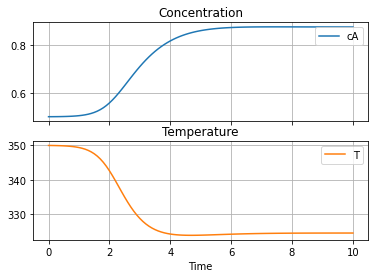

In [41]:
# simulation
IC = [cA0, T0]
t_final = 10.0
soln = solve_ivp(deriv, [0, t_final], IC, max_step=0.1)

df = pd.DataFrame(soln.y.T, columns=["cA", "T"])
df["Time"] = soln.t

df.plot(x="Time", subplots=True, grid=True, title=["Concentration", "Temperature"])

## Effect of Cooling Temperature

The primary means of controlling the reactoris through temperature of the cooling water jacket. The next calculations explore the effect of plus or minus change of 5 K in cooling water temperature on reactor behavior. These simulations reproduce the behavior shown in Example 2.5 SEMD.

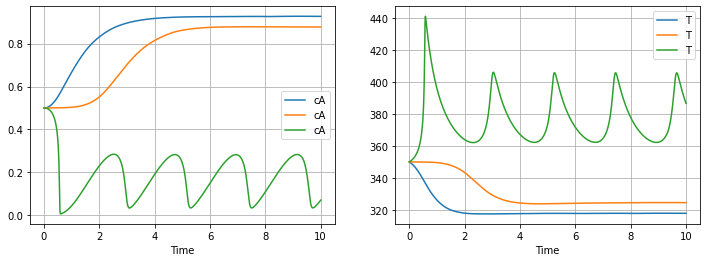

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
for Tc in [295, 300, 305]:
    soln = solve_ivp(deriv, [t_initial, t_final], IC, t_eval=t)
    df = pd.DataFrame(soln.y.T, columns=["cA", "T"])
    df["Time"] = soln.t
    df.plot(x="Time", y="cA", ax=ax[0], grid=True)
    df.plot(x="Time", y="T", ax=ax[1], grid=True)

## Interactive Simulation

Executing the following cell provides an interactive tool for exploring the relationship of cooling temperature with reactor behavior.  Use it to observe a thermal runaway, sustained osciallations, and low and high conversion steady states.

In [5]:
from ipywidgets import interact
from IPython.display import display

# create an initial plot object, and close so it doesn't appear
Tc = 300.0
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
soln = solve_ivp(deriv, [t_initial, t_final], IC, t_eval=t)
plot_reactor(ax, soln.t, soln.y)
plt.close()

# function to update and display the plot object
def sim(Tcooling):
    global Tc
    Tc = Tcooling
    soln = solve_ivp(deriv, [t_initial, t_final], IC, t_eval=t)
    ax[0].lines[0].set_ydata(soln.y[0])
    ax[0].legend().get_texts()[0].set_text(str(Tc))
    ax[1].lines[0].set_ydata(soln.y[1])
    ax[1].legend().get_texts()[0].set_text(str(Tc))
    display(fig)

# interactive widget
interact(sim, Tcooling = (290.0, 310.0), continuous_update=False);

interactive(children=(FloatSlider(value=300.0, description='Tcooling', max=310.0, min=290.0), Output()), _dom_…

## Nullclines

The nullclines of two first-order differential equations are points in the phase plane for which one or the other of the two derivatives are zero.

\begin{align*}
V\frac{dc_A}{dt} & = 0 = q(c_{Ai}-c_A)-Vkc_A \\
V\rho C_p\frac{dT}{dt} & = 0 = wC_p(T_i-T) + (-\Delta H_R)Vkc_A + UA(T_c-T)
\end{align*}

The intersection of the nullclines correspond to steady states. The relative positions of the nullclines provide valuable insight into the dynamics of a nonlinear system.

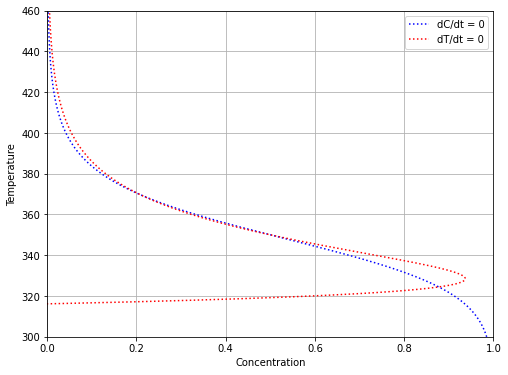

In [6]:
# plot nullclines

def plot_nullclines(ax):
    T = np.linspace(300.0,460.0,1000)
    ax.plot((q/V)*cAi/((q/V) + k(T)), T, 'b:')
    ax.plot(((q/V)*(Ti-T) + (UA/V/rho/Cp)*(Tc-T))/((dHr/rho/Cp)*k(T)), T, 'r:')
    ax.set_xlim(0,1)
    ax.set_ylim(300,460)
    ax.grid()
    ax.legend(['dC/dt = 0','dT/dt = 0'])
    ax.set_xlabel('Concentration')
    ax.set_ylabel('Temperature')
    
fix, ax = plt.subplots(1, 1, figsize=(8,6))
plot_nullclines(ax)

## Phase Plane Analysis

The final analysis is display the simulation in both time and phase plane coordinates. The following cell produces a 

In [7]:
def plot_phase(ax, t, y):
    ax.plot(y[0][0], y[1][0], 'r.', ms=20)
    ax.plot(y[0], y[1], 'g', lw=2)

def phase(cinitial=0.5, Tinitial=350):
    global Tc
    soln = solve_ivp(deriv, [t_initial, t_final], [cinitial,Tinitial], t_eval=t)
    
    ax[0,0].lines[2].set_xdata(soln.y[0][0])
    ax[0,0].lines[2].set_ydata(soln.y[1][0])
    ax[0,0].lines[3].set_xdata(soln.y[0])
    ax[0,0].lines[3].set_ydata(soln.y[1])
    ax[1,0].lines[0].set_ydata(soln.y[0])
    ax[1,1].lines[0].set_ydata(soln.y[1])
    display(fig)
    
Tc = 300.0
cinitial = 0.5
Tinitial = 350.0
fig, ax = plt.subplots(2, 2, figsize=(12, 9))
soln = solve_ivp(deriv, [t_initial, t_final], [cinitial, Tinitial], t_eval=t)
plot_nullclines(ax[0,0])
plot_phase(ax[0,0], soln.t, soln.y)
plot_reactor(ax[1,:], soln.t, soln.y)
plt.close()

interact(phase, cinitial=(0,1,.01), Tinitial=(300,400,1))

interactive(children=(FloatSlider(value=0.5, description='cinitial', max=1.0, step=0.01), IntSlider(value=350,…

<function __main__.phase(cinitial=0.5, Tinitial=350)>

## Suggested Exercises

**1.** Using the interactive simulation, adjust the cooling temperature over the range of values from 290K to 310K, identify the cooling water temperatures at which you observe a qualitative difference in system behavior. Try to identify the following behaviors:

* Stable steady state
* Oscillatory steady state
* The onset of a thermal runaway condition


**2.** Repeat the exercise using the phase plane simulation. Describe the underlying behaviors in light of the nullclines.



**3.** Assume the reactor is start up with a tank of reactant feed with a concentration $c_A = 1$. What is the maximum initial temperature that would avoid thermal runaway during reactor startup?